# AUEB M.Sc. in Data Science (part-time)

**Course**: Text Analytics

**Semester**: Spring 2018

**4th homework**: Sentiment analysis on a Twitter dataset of a large number of tweets, using RNNs with Keras (training notebook).

**Team members**:

- Alexandros Kaplanis (https://github.com/AlexcapFF/)
- Spiros Politis
- Manos Proimakis (https://github.com/manosprom)

---

## Homework

Repeat Exercise 10 of Part 3 (text classification with MLPs), now using a bi-directional stacked RNN (with GRU or LSTM cells) and a self-attention MLP , all implemented (by you) in Keras, TensorFlow, PyTorch, or DyNet. Tune the hyper-parameters (e.g. number of stacked RNNs, number of hidden layers in the self-attention MLP) on a held-out part of the training data or using a cross-validation on the training data. You may optionally add an extra RNN layer to produce word embeddings from characters, concatenating each resulting character-based word embedding with the corresponding pre-trained (e.g. via Word2Vec) word embedding. You may optionally add a pre-trained language model (e.g., ELMo) as an extra layer to obtain context-sensitive word embeddings.

---

## Required packages and classes

In [1]:
import sys
import os
import itertools
import collections 
import pickle

import numpy as np

import sklearn.model_selection
import sklearn

import keras.preprocessing.text
import keras.preprocessing.sequence
import keras.callbacks
import keras.optimizers

import keras_tqdm

import matplotlib.pyplot as plt

# Import required classes, implemented for the assignment.
sys.path.append('src')

import utilities, preprocessing
from RNN import RNN

%matplotlib inline

Using TensorFlow backend.


## Data ingestion

In [2]:
original_training_df = utilities.create_dataset(
    'data/training.1600000.processed.noemoticon.csv', 
    sys.maxsize
)

original_test_df = utilities.create_dataset(
    'data/testdata.manual.2009.06.14.csv', 
    sys.maxsize
)

### Inspection of our training set

In [3]:
display(original_training_df.head(10))

print("Size: ", len(original_training_df))

,polarity,date,query,user,text
id,,,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
1467811372,0,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
1467811592,0,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
1467811594,0,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
1467811795,0,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it


Size:  1600000


### Inspection of our test set

In [4]:
display(original_test_df.head(10))

print("Size: ", len(original_test_df))

,polarity,date,query,user,text
id,,,,,
9,0,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non loan given asses.
14,0,Mon May 11 03:32:48 UTC 2009,obama,kylesellers,"@Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil. It's a charade and a slogan, but they want to destroy conservatism"
17,0,Mon May 11 05:06:22 UTC 2009,nike,vincentx24x,"dear nike, stop with the flywire. that shit is a waste of science. and ugly. love, @vincentx24x"
19,0,Mon May 11 05:20:28 UTC 2009,lebron,luv8242,I was talking to this guy last night and he was telling me that he is a die hard Spurs fan. He also told me that he hates LeBron James.
21,0,Mon May 11 05:21:37 UTC 2009,lebron,ursecretdezire,"@ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end."
119,0,Sat May 16 16:19:24 UTC 2009,google,vamsmack,Played with an android google phone. The slide out screen scares me I would break that fucker so fast. Still prefer my iPhone.
120,0,Sat May 16 16:25:41 UTC 2009,aig,schroncd,US planning to resume the military tribunals at Guantanamo Bay... only this time those on trial will be AIG execs and Chrysler debt holders
121,0,Sat May 16 22:42:07 UTC 2009,itchy,MarissaLeeD,omg so bored &amp; my tattoooos are so itchy!! help! aha =)
122,0,Sat May 16 22:42:25 UTC 2009,itchy,robloposky,I'm itchy and miserable!


Size:  359


how are the categories of tweets distrubuted between positive and negative

Text(0.5,1,'Dataset labels distribuition')

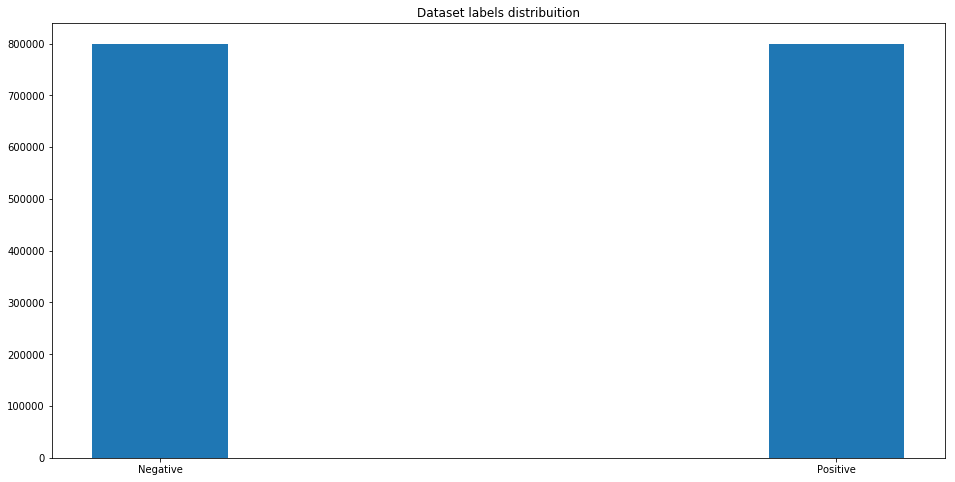

In [5]:
target_cnt = collections.Counter(original_training_df['polarity'])

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.xticks([0, 4], ['Negative', 'Positive'])
plt.title("Dataset labels distribuition")

## Sampling

In order to ensure that our train / dev/ test / heldout sets follow the same probability distribution, since the dataset contains many samples and because half of them is Negative(0) and the other half is Positive(4) we cannot just take N random number of rows from the whole dataset and we need to distribute it beside the positive and negative samples which will be done as below.

The dataset contains thes same size of rows for Negative and Positive tweets, here we will keep a balanced set of 50000 positive and 50000 negative tweets taken randomly.

In [6]:
training_df = utilities.take_n_samples_from_each_category(original_training_df, 50000)

## Preprocessing

In [7]:
df = training_df.copy()
df['text_before_preprocess'] = df['text']
df.drop(columns=['date', 'query'], axis=1, inplace=True)
df['length_before_preprocess'] = df['text_before_preprocess'].str.len()
df.reset_index(drop=True, inplace=True)

In [8]:
df['text']= df['text'].apply(lambda row: preprocessing.preprocess_row(row))
df['length'] = df['text'].str.len()

### Keep only relevant data
We keep only the list of texts to create the embeddings
and the list of the polarity per tweet as target

In [9]:
corpus = df['text'].values.tolist()
target = df['polarity'].values.tolist()

In [10]:
df = df.drop_duplicates(subset=['user','text'], keep = 'first')

In [11]:
df.drop(columns=['user'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

## Train / heldout / dev sets

- Τraining set: will be used for the training of our RNN
- Heldout set: will be used for hyperparameter tuning
- Development (validation) set: will be used to monitor the performance of our RNN during training and optimization process

We have employed the established 50/25/25 rule.

In [12]:
X_train, X_heldout_dev, y_train, y_heldout_dev = sklearn.model_selection.train_test_split(
    corpus, 
    target, 
    test_size = 0.25, 
    shuffle = True
)

X_heldout, X_dev, y_heldout, y_dev = sklearn.model_selection.train_test_split(
    X_heldout_dev, 
    y_heldout_dev, 
    test_size = 0.5, 
    shuffle = True
)

In [13]:
print('Size of X_train: ', len(X_train))
print('Size of X_heldout: ', len(X_heldout))
print('Size of X_dev: ', len(X_dev))
print('Size of y_train: ', len(y_train))
print('Size of y_heldout: ', len(y_heldout))
print('Size of y_dev: ', len(y_dev))

Size of X_train:  75000
Size of X_heldout:  12500
Size of X_dev:  12500
Size of y_train:  75000
Size of y_heldout:  12500
Size of y_dev:  12500


In [14]:
df_test = original_test_df.copy()
df_test.drop(columns=['date', 'query', 'user'], axis=1, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_test['text']= df_test['text'].apply(lambda row: preprocessing.preprocess_row(row))
X_test = df_test['text'].values.tolist()
y_test = df_test['polarity'].values.tolist()

In [15]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

le = sklearn.preprocessing.LabelEncoder()
le.fit(y_dev)
y_dev = le.transform(y_dev)

le = sklearn.preprocessing.LabelEncoder()
le.fit(y_heldout)
y_heldout = le.transform(y_heldout)

le = sklearn.preprocessing.LabelEncoder()
le.fit(y_test)
y_test = le.transform(y_test)

## Creating word embeddings

### FastText embedings

In [16]:
idx = 0
vocab = {}

# Check if FastText embeddings exist on the file system...
if(not os.path.isfile('./fasttext.npy')):
    # If not, donwload and gunzip the FastText vectors file...
    if(not os.path.isfile('cc.en.300.vec')):
        if(not os.path.isfile('./cc.en.300.vec.gz')):
            !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

        !gzip -d cc.en.300.vec.gz
    
    with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
        for l in f:
            line = l.rstrip().split(' ')
            if idx == 0:
                vocab_size = int(line[0]) + 2
                dim = int(line[1])
                vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
                vocab["__PADDING__"] = 0
                vocab["__UNK__"] = 1
                idx = 2
            else:
                vocab[line[0]] = idx
                emb = np.array(line[1:]).astype(np.float)
                if (emb.shape[0] == dim):
                    vecs[idx,:] = emb
                    idx+=1
                else:
                    continue

        pickle.dump(vocab,open("fasttext_vocabulary",'wb'))
        
        np.save("fasttext.npy",vecs)

In [17]:
fasttext_embed = np.load("fasttext.npy")
fasttext_word_to_index = pickle.load(open("fasttext_vocabulary", "rb"))

In [18]:
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [19]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words = MAX_WORDS,oov_token = '__UNK__')
tokenizer.fit_on_texts(X_train)

train_seqs = tokenizer.texts_to_sequences(X_train)
heldout_seqs = tokenizer.texts_to_sequences(X_heldout)
dev_seqs = tokenizer.texts_to_sequences(X_dev)
test_seqs = tokenizer.texts_to_sequences(X_test)

train_data = keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen = MAX_SEQUENCE_LENGTH,padding = 'post')
heldout_data = keras.preprocessing.sequence.pad_sequences(heldout_seqs, maxlen = MAX_SEQUENCE_LENGTH,padding = 'post')
dev_data = keras.preprocessing.sequence.pad_sequences(dev_seqs, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
test_data = keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

In [20]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 46052 unique tokens.


In [21]:
# Save the tokenizer for inference.
with open('models/tokenizer', 'wb') as handle:
    pickle.dump(tokenizer, handle)

### Initialize embedding matrix with fasttext pre-trained embedings

In [22]:
embeddings_matrix = np.zeros((MAX_WORDS + 2, EMBEDDINGS_DIM))

for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embeddings_matrix[i] = embedding_vector
    except:
        pass

## Baseline model experiments

In [23]:
def checkpoint(name):
    return keras.callbacks.ModelCheckpoint(
        name, 
        monitor = 'val_f1', 
        verbose = 1, 
        save_best_only = True, 
        mode = 'max'
    )

early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min',
    patience = 5,
    verbose = 1 
)

### RNN with GRU cells

We create a RNN with GRU cells having the following architecture:

- An embedding layer
- A dropout layer with 0.2 probability
- A bidirectional GRU layer with 0.2 variational (recurrent) dropout
- A self-attention layer with linear / deep attention
- A hidden MLP layer
- An output MLP layer

Subsequently, we will experiment with a few parameters of the RNN, namely the number of GRU neurons and the MLP number of neurons.

Normally we would use smaller batch size. In this case since it takes much to time to train the model in batches of 32 or 64 items we used 1000 items
on all of the baseline models.

#### GRU size: 50, MLP size: 50, with linear self-attention

In [24]:
GRU_NUM_NEURONS = 50
DENSE_NUM_NEURONS = 50
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [25]:
rnn_gru_50_50_l = RNN()
rnn_gru_50_50_l = rnn_gru_50_50_l \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix, 
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .gru_layer(
        units = GRU_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'gru_layer'
    ) \
    .linear_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

W0715 23:35:01.476819 140581372839744 deprecation_wrapper.py:119] From /home/sp/anaconda3/envs/msc-ds-core-ta-homework-4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 23:35:01.485358 140581372839744 deprecation_wrapper.py:119] From /home/sp/anaconda3/envs/msc-ds-core-ta-homework-4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 23:35:01.489775 140581372839744 deprecation_wrapper.py:119] From /home/sp/anaconda3/envs/msc-ds-core-ta-homework-4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0715 23:35:01.490088 140581372839744 deprecation_wrapper.py:119] From /home/sp/anaconda3/envs/msc-ds-core-ta-homework-4/lib/python3.6/site-packages/keras/backend

In [26]:
rnn_gru_50_50_l = rnn_gru_50_50_l.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/GRU_50_50_l'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.75819, saving model to models/GRU_50_50_l



Epoch 00002: val_f1 did not improve from 0.75819



Epoch 00003: val_f1 improved from 0.75819 to 0.76219, saving model to models/GRU_50_50_l



Epoch 00004: val_f1 improved from 0.76219 to 0.77912, saving model to models/GRU_50_50_l



Epoch 00005: val_f1 did not improve from 0.77912



Epoch 00006: val_f1 improved from 0.77912 to 0.78311, saving model to models/GRU_50_50_l



Epoch 00007: val_f1 did not improve from 0.78311



Epoch 00008: val_f1 did not improve from 0.78311



Epoch 00009: val_f1 improved from 0.78311 to 0.79489, saving model to models/GRU_50_50_l



Epoch 00010: val_f1 improved from 0.79489 to 0.79679, saving model to models/GRU_50_50_l



Epoch 00011: val_f1 did not improve from 0.79679



Epoch 00012: val_f1 did not improve from 0.79679



Epoch 00013: val_f1 improved from 0.79679 to 0.80039, saving model to models/GRU_50_50_l



Epoch 00014: val_f1 did not improve from 0.80039



Epoch 00015: val_f1 did not improve from 0.80039



Epoch 00016: val_f1 did not improve from 0.80039



Epoch 00017: val_f1 did not improve from 0.80039



Epoch 00018: val_f1 improved from 0.80039 to 0.80188, saving model to models/GRU_50_50_l



Epoch 00019: val_f1 did not improve from 0.80188



Epoch 00020: val_f1 did not improve from 0.80188



Epoch 00021: val_f1 did not improve from 0.80188



Epoch 00022: val_f1 improved from 0.80188 to 0.80900, saving model to models/GRU_50_50_l



Epoch 00023: val_f1 did not improve from 0.80900



Epoch 00024: val_f1 did not improve from 0.80900



Epoch 00025: val_f1 did not improve from 0.80900



Epoch 00026: val_f1 did not improve from 0.80900



Epoch 00027: val_f1 did not improve from 0.80900



Epoch 00028: val_f1 did not improve from 0.80900



Epoch 00029: val_f1 did not improve from 0.80900



Epoch 00030: val_f1 did not improve from 0.80900



Epoch 00031: val_f1 did not improve from 0.80900



Epoch 00032: val_f1 did not improve from 0.80900



Epoch 00033: val_f1 did not improve from 0.80900



Epoch 00034: val_f1 did not improve from 0.80900
Epoch 00034: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 100)          105300    
_________________________________________________________________
linear_attention_1 (LinearAt (None, 100)               101       
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 100)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 50)                5050      
__________

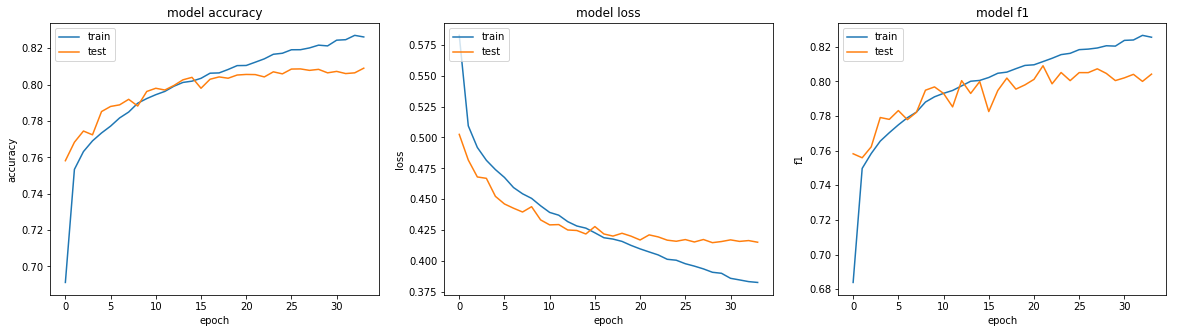

In [27]:
print(rnn_gru_50_50_l.model.summary())

utilities.plot_history(rnn_gru_50_50_l.history)

utilities.print_evaluation(rnn_gru_50_50_l.model, dev_data, y_dev)

#### GRU size: 50, MLP size: 50, with deep self-attention

In [28]:
GRU_NUM_NEURONS = 50
DENSE_NUM_NEURONS = 50
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [29]:
rnn_gru_50_50_d = RNN()
rnn_gru_50_50_d = rnn_gru_50_50_d \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .gru_layer(
        units = GRU_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'gru_layer'
    ) \
    .deep_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [30]:
rnn_gru_50_50_d = rnn_gru_50_50_d.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/GRU_50_50_d'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.73517, saving model to models/GRU_50_50_d



Epoch 00002: val_f1 improved from 0.73517 to 0.75679, saving model to models/GRU_50_50_d



Epoch 00003: val_f1 improved from 0.75679 to 0.77909, saving model to models/GRU_50_50_d



Epoch 00004: val_f1 did not improve from 0.77909



Epoch 00005: val_f1 did not improve from 0.77909



Epoch 00006: val_f1 improved from 0.77909 to 0.78372, saving model to models/GRU_50_50_d



Epoch 00007: val_f1 improved from 0.78372 to 0.79113, saving model to models/GRU_50_50_d



Epoch 00008: val_f1 did not improve from 0.79113



Epoch 00009: val_f1 improved from 0.79113 to 0.79156, saving model to models/GRU_50_50_d



Epoch 00010: val_f1 improved from 0.79156 to 0.79732, saving model to models/GRU_50_50_d



Epoch 00011: val_f1 did not improve from 0.79732



Epoch 00012: val_f1 did not improve from 0.79732



Epoch 00013: val_f1 improved from 0.79732 to 0.80287, saving model to models/GRU_50_50_d



Epoch 00014: val_f1 did not improve from 0.80287



Epoch 00015: val_f1 did not improve from 0.80287



Epoch 00016: val_f1 did not improve from 0.80287



Epoch 00017: val_f1 did not improve from 0.80287



Epoch 00018: val_f1 did not improve from 0.80287



Epoch 00019: val_f1 did not improve from 0.80287



Epoch 00020: val_f1 did not improve from 0.80287



Epoch 00021: val_f1 improved from 0.80287 to 0.80528, saving model to models/GRU_50_50_d



Epoch 00022: val_f1 did not improve from 0.80528



Epoch 00023: val_f1 did not improve from 0.80528



Epoch 00024: val_f1 did not improve from 0.80528



Epoch 00025: val_f1 did not improve from 0.80528



Epoch 00026: val_f1 did not improve from 0.80528



Epoch 00027: val_f1 improved from 0.80528 to 0.80795, saving model to models/GRU_50_50_d



Epoch 00028: val_f1 did not improve from 0.80795



Epoch 00029: val_f1 did not improve from 0.80795
Epoch 00029: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 100)          105300    
_________________________________________________________________
deep_attention_1 (DeepAttent (None, 100)               10201     
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 100)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 50)                5050      
__________

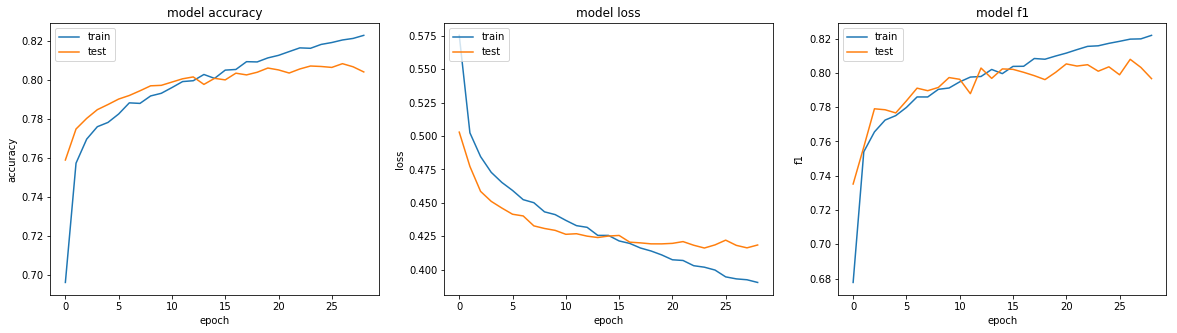

In [31]:
print(rnn_gru_50_50_d.model.summary())

utilities.plot_history(rnn_gru_50_50_d.history)

utilities.print_evaluation(rnn_gru_50_50_d.model, dev_data, y_dev)

Monitoring the performance of *deep* versus *linear* self attention and making sure all parameters are equal, we come to the conclusion that the experiments that will follow should keep the *linear* attention layer and focus on the number of GRU cells of the RNN.

#### GRU size: 100, MLP size: 100, linear self-attention

In [32]:
GRU_NUM_NEURONS = 100
DENSE_NUM_NEURONS = 100
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [33]:
rnn_gru_100_100_l = RNN()
rnn_gru_100_100_l = rnn_gru_100_100_l \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .gru_layer(
        units = GRU_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'gru_layer'
    ) \
    .linear_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [34]:
rnn_gru_100_100_l = rnn_gru_100_100_l.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/GRU_100_100_l'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.76605, saving model to models/GRU_100_100_l



Epoch 00002: val_f1 improved from 0.76605 to 0.77356, saving model to models/GRU_100_100_l



Epoch 00003: val_f1 improved from 0.77356 to 0.77492, saving model to models/GRU_100_100_l



Epoch 00004: val_f1 improved from 0.77492 to 0.78835, saving model to models/GRU_100_100_l



Epoch 00005: val_f1 improved from 0.78835 to 0.79144, saving model to models/GRU_100_100_l



Epoch 00006: val_f1 did not improve from 0.79144



Epoch 00007: val_f1 did not improve from 0.79144



Epoch 00008: val_f1 improved from 0.79144 to 0.79324, saving model to models/GRU_100_100_l



Epoch 00009: val_f1 did not improve from 0.79324



Epoch 00010: val_f1 did not improve from 0.79324



Epoch 00011: val_f1 improved from 0.79324 to 0.79559, saving model to models/GRU_100_100_l



Epoch 00012: val_f1 did not improve from 0.79559



Epoch 00013: val_f1 improved from 0.79559 to 0.79752, saving model to models/GRU_100_100_l



Epoch 00014: val_f1 improved from 0.79752 to 0.79828, saving model to models/GRU_100_100_l



Epoch 00015: val_f1 did not improve from 0.79828



Epoch 00016: val_f1 did not improve from 0.79828



Epoch 00017: val_f1 did not improve from 0.79828



Epoch 00018: val_f1 improved from 0.79828 to 0.80054, saving model to models/GRU_100_100_l



Epoch 00019: val_f1 did not improve from 0.80054



Epoch 00020: val_f1 did not improve from 0.80054



Epoch 00021: val_f1 did not improve from 0.80054



Epoch 00022: val_f1 improved from 0.80054 to 0.80130, saving model to models/GRU_100_100_l



Epoch 00023: val_f1 improved from 0.80130 to 0.80576, saving model to models/GRU_100_100_l



Epoch 00024: val_f1 did not improve from 0.80576



Epoch 00025: val_f1 did not improve from 0.80576



Epoch 00026: val_f1 improved from 0.80576 to 0.80643, saving model to models/GRU_100_100_l



Epoch 00027: val_f1 did not improve from 0.80643



Epoch 00028: val_f1 improved from 0.80643 to 0.80796, saving model to models/GRU_100_100_l



Epoch 00029: val_f1 did not improve from 0.80796



Epoch 00030: val_f1 did not improve from 0.80796
Epoch 00030: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 200)          240600    
_________________________________________________________________
linear_attention_2 (LinearAt (None, 200)               201       
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 200)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 100)               20100     
__________

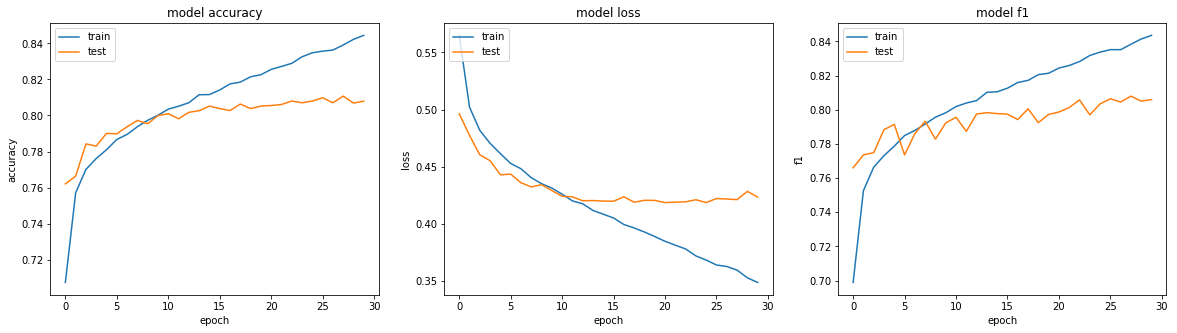

In [35]:
print(rnn_gru_100_100_l.model.summary())

utilities.plot_history(rnn_gru_100_100_l.history)

utilities.print_evaluation(rnn_gru_100_100_l.model, dev_data, y_dev)

#### GRU size: 100, MLP size: 100, deep self-attention

In [36]:
GRU_NUM_NEURONS = 100
DENSE_NUM_NEURONS = 100
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [37]:
rnn_gru_100_100_d = RNN()
rnn_gru_100_100_d = rnn_gru_100_100_d \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .gru_layer(
        units = GRU_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'gru_layer'
    ) \
    .deep_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [38]:
rnn_gru_100_100_d = rnn_gru_100_100_d.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/GRU_100_100_d'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.75929, saving model to models/GRU_100_100_d



Epoch 00002: val_f1 improved from 0.75929 to 0.77368, saving model to models/GRU_100_100_d



Epoch 00003: val_f1 improved from 0.77368 to 0.78517, saving model to models/GRU_100_100_d



Epoch 00004: val_f1 improved from 0.78517 to 0.79183, saving model to models/GRU_100_100_d



Epoch 00005: val_f1 did not improve from 0.79183



Epoch 00006: val_f1 improved from 0.79183 to 0.79264, saving model to models/GRU_100_100_d



Epoch 00007: val_f1 improved from 0.79264 to 0.79674, saving model to models/GRU_100_100_d



Epoch 00008: val_f1 improved from 0.79674 to 0.80142, saving model to models/GRU_100_100_d



Epoch 00009: val_f1 did not improve from 0.80142



Epoch 00010: val_f1 did not improve from 0.80142



Epoch 00011: val_f1 improved from 0.80142 to 0.80686, saving model to models/GRU_100_100_d



Epoch 00012: val_f1 did not improve from 0.80686



Epoch 00013: val_f1 did not improve from 0.80686



Epoch 00014: val_f1 did not improve from 0.80686



Epoch 00015: val_f1 did not improve from 0.80686



Epoch 00016: val_f1 did not improve from 0.80686



Epoch 00017: val_f1 improved from 0.80686 to 0.80947, saving model to models/GRU_100_100_d



Epoch 00018: val_f1 did not improve from 0.80947



Epoch 00019: val_f1 did not improve from 0.80947



Epoch 00020: val_f1 did not improve from 0.80947



Epoch 00021: val_f1 did not improve from 0.80947



Epoch 00022: val_f1 did not improve from 0.80947



Epoch 00023: val_f1 did not improve from 0.80947



Epoch 00024: val_f1 did not improve from 0.80947
Epoch 00024: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 200)          240600    
_________________________________________________________________
deep_attention_2 (DeepAttent (None, 200)               40401     
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 200)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 100)               20100     
__________

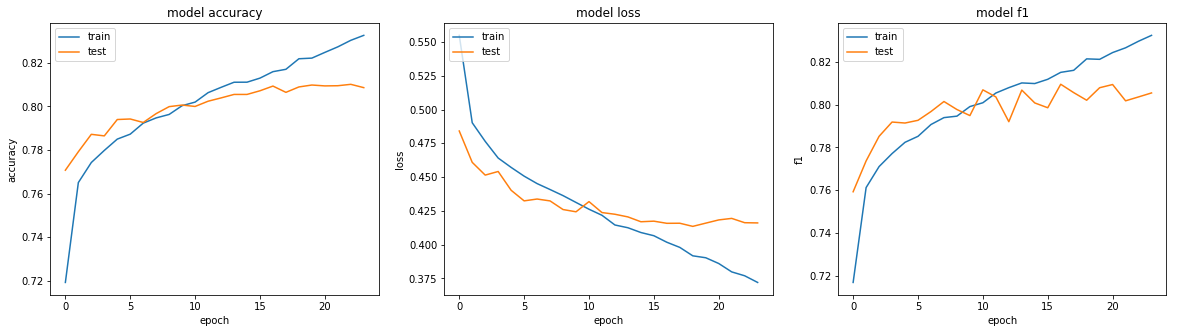

In [39]:
print(rnn_gru_100_100_d.model.summary())

utilities.plot_history(rnn_gru_100_100_d.history)

utilities.print_evaluation(rnn_gru_100_100_d.model, dev_data, y_dev)

Noticing that the f1 score increases slightly, we attribute the increase in performance to the number of neurons of the GRU and MLP layer, we therefore we shall proceed with testing yet another model with an increased number of such parameters.

#### GRU size: 200, MLP size: 200, deep self-attention

In [40]:
GRU_NUM_NEURONS = 200
DENSE_NUM_NEURONS = 200
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [41]:
rnn_gru_200_200_d = RNN()
rnn_gru_200_200_d = rnn_gru_200_200_d \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .gru_layer(
        units = GRU_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'gru_layer'
    ) \
    .deep_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [42]:
rnn_gru_200_200_d = rnn_gru_200_200_d.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/GRU_200_200_d'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.75585, saving model to models/GRU_200_200_d



Epoch 00002: val_f1 improved from 0.75585 to 0.77318, saving model to models/GRU_200_200_d



Epoch 00003: val_f1 improved from 0.77318 to 0.77421, saving model to models/GRU_200_200_d



Epoch 00004: val_f1 improved from 0.77421 to 0.79012, saving model to models/GRU_200_200_d



Epoch 00005: val_f1 did not improve from 0.79012



Epoch 00006: val_f1 did not improve from 0.79012



Epoch 00007: val_f1 did not improve from 0.79012



Epoch 00008: val_f1 improved from 0.79012 to 0.79522, saving model to models/GRU_200_200_d



Epoch 00009: val_f1 did not improve from 0.79522



Epoch 00010: val_f1 did not improve from 0.79522



Epoch 00011: val_f1 did not improve from 0.79522



Epoch 00012: val_f1 did not improve from 0.79522



Epoch 00013: val_f1 improved from 0.79522 to 0.80057, saving model to models/GRU_200_200_d



Epoch 00014: val_f1 improved from 0.80057 to 0.80248, saving model to models/GRU_200_200_d



Epoch 00015: val_f1 did not improve from 0.80248



Epoch 00016: val_f1 improved from 0.80248 to 0.80366, saving model to models/GRU_200_200_d



Epoch 00017: val_f1 did not improve from 0.80366



Epoch 00018: val_f1 did not improve from 0.80366
Epoch 00018: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 400)          601200    
_________________________________________________________________
deep_attention_3 (DeepAttent (None, 400)               160801    
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 400)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 200)               80200     
__________

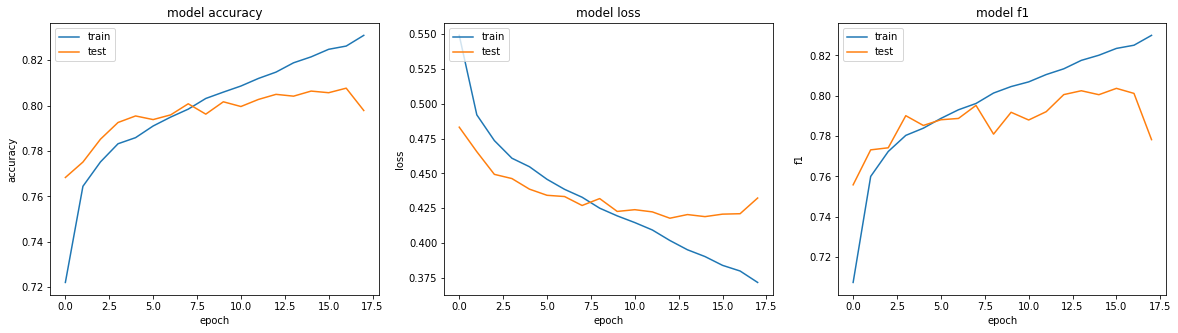

In [43]:
print(rnn_gru_200_200_d.model.summary())

utilities.plot_history(rnn_gru_200_200_d.history)

utilities.print_evaluation(rnn_gru_200_200_d.model, dev_data, y_dev)

#### 2 stacked RNNs, GRU size: 100, MLP size: 100, with deep self-attention

In [44]:
GRU_NUM_NEURONS = 100
DENSE_NUM_NEURONS = 100
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [45]:
rnn_gru_100_100_stacked_l = RNN()
rnn_gru_100_100_stacked_l = rnn_gru_100_100_stacked_l \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .gru_layer(
        units = GRU_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'gru_layer_1'
    ) \
    .gru_layer(
        units = GRU_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'gru_layer_2'
    ) \
    .deep_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [46]:
rnn_gru_100_100_stacked_l = rnn_gru_100_100_stacked_l.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/GRU_100_100_stacked_l'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.72901, saving model to models/GRU_100_100_stacked_l



Epoch 00002: val_f1 improved from 0.72901 to 0.76425, saving model to models/GRU_100_100_stacked_l



Epoch 00003: val_f1 improved from 0.76425 to 0.78225, saving model to models/GRU_100_100_stacked_l



Epoch 00004: val_f1 improved from 0.78225 to 0.78720, saving model to models/GRU_100_100_stacked_l



Epoch 00005: val_f1 improved from 0.78720 to 0.79079, saving model to models/GRU_100_100_stacked_l



Epoch 00006: val_f1 did not improve from 0.79079



Epoch 00007: val_f1 did not improve from 0.79079



Epoch 00008: val_f1 improved from 0.79079 to 0.79655, saving model to models/GRU_100_100_stacked_l



Epoch 00009: val_f1 improved from 0.79655 to 0.80061, saving model to models/GRU_100_100_stacked_l



Epoch 00010: val_f1 did not improve from 0.80061



Epoch 00011: val_f1 improved from 0.80061 to 0.80401, saving model to models/GRU_100_100_stacked_l



Epoch 00012: val_f1 improved from 0.80401 to 0.80565, saving model to models/GRU_100_100_stacked_l



Epoch 00013: val_f1 did not improve from 0.80565



Epoch 00014: val_f1 did not improve from 0.80565



Epoch 00015: val_f1 did not improve from 0.80565



Epoch 00016: val_f1 did not improve from 0.80565



Epoch 00017: val_f1 did not improve from 0.80565



Epoch 00018: val_f1 did not improve from 0.80565



Epoch 00019: val_f1 improved from 0.80565 to 0.80946, saving model to models/GRU_100_100_stacked_l



Epoch 00020: val_f1 did not improve from 0.80946



Epoch 00021: val_f1 improved from 0.80946 to 0.81089, saving model to models/GRU_100_100_stacked_l



Epoch 00022: val_f1 did not improve from 0.81089
Epoch 00022: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer_1 (Bidirectional)  (None, 100, 200)          240600    
_________________________________________________________________
gru_layer_2 (Bidirectional)  (None, 100, 200)          180600    
_________________________________________________________________
deep_attention_4 (DeepAttent (None, 200)               40401     
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 200)               0         
__________

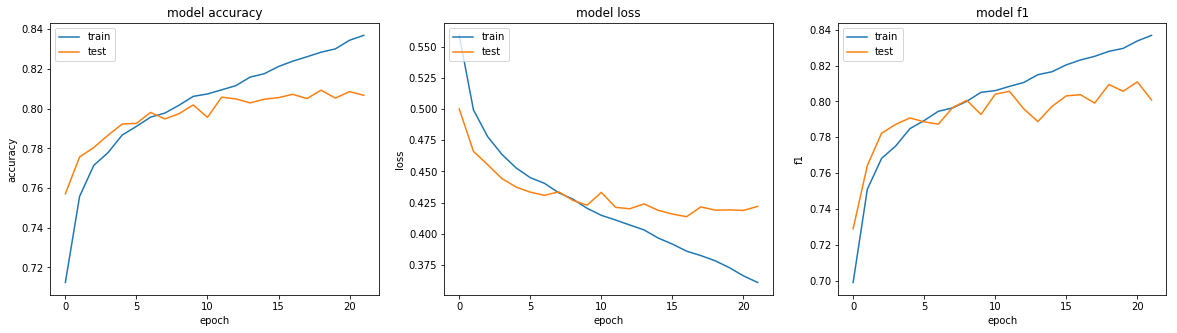

In [47]:
print(rnn_gru_100_100_stacked_l.model.summary())

utilities.plot_history(rnn_gru_100_100_stacked_l.history)

utilities.print_evaluation(rnn_gru_100_100_stacked_l.model, dev_data, y_dev)

### RNN with LSTM cells

#### LSTM size: 50, MLP size: 50, linear self-attention

In [48]:
LSTM_NUM_NEURONS = 50
DENSE_NUM_NEURONS = 50
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [49]:
rnn_lstm_50_50_l = RNN()
rnn_lstm_50_50_l = rnn_lstm_50_50_l \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix, 
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .lstm_layer(
        units = LSTM_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'lstm_layer'
    ) \
    .linear_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'linear_attention_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [50]:
rnn_lstm_50_50_l = rnn_lstm_50_50_l.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/LSTM_50_50_l'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.73594, saving model to models/LSTM_50_50_l



Epoch 00002: val_f1 improved from 0.73594 to 0.74829, saving model to models/LSTM_50_50_l



Epoch 00003: val_f1 improved from 0.74829 to 0.75824, saving model to models/LSTM_50_50_l



Epoch 00004: val_f1 improved from 0.75824 to 0.77124, saving model to models/LSTM_50_50_l



Epoch 00005: val_f1 improved from 0.77124 to 0.77468, saving model to models/LSTM_50_50_l



Epoch 00006: val_f1 did not improve from 0.77468



Epoch 00007: val_f1 improved from 0.77468 to 0.78281, saving model to models/LSTM_50_50_l



Epoch 00008: val_f1 did not improve from 0.78281



Epoch 00009: val_f1 did not improve from 0.78281



Epoch 00010: val_f1 improved from 0.78281 to 0.79180, saving model to models/LSTM_50_50_l



Epoch 00011: val_f1 did not improve from 0.79180



Epoch 00012: val_f1 did not improve from 0.79180



Epoch 00013: val_f1 improved from 0.79180 to 0.79694, saving model to models/LSTM_50_50_l



Epoch 00014: val_f1 did not improve from 0.79694



Epoch 00015: val_f1 did not improve from 0.79694



Epoch 00016: val_f1 improved from 0.79694 to 0.79824, saving model to models/LSTM_50_50_l



Epoch 00017: val_f1 improved from 0.79824 to 0.79836, saving model to models/LSTM_50_50_l



Epoch 00018: val_f1 did not improve from 0.79836



Epoch 00019: val_f1 did not improve from 0.79836



Epoch 00020: val_f1 improved from 0.79836 to 0.80408, saving model to models/LSTM_50_50_l



Epoch 00021: val_f1 did not improve from 0.80408



Epoch 00022: val_f1 did not improve from 0.80408



Epoch 00023: val_f1 did not improve from 0.80408



Epoch 00024: val_f1 did not improve from 0.80408



Epoch 00025: val_f1 did not improve from 0.80408



Epoch 00026: val_f1 improved from 0.80408 to 0.80437, saving model to models/LSTM_50_50_l



Epoch 00027: val_f1 did not improve from 0.80437



Epoch 00028: val_f1 did not improve from 0.80437



Epoch 00029: val_f1 did not improve from 0.80437
Epoch 00029: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
lstm_layer (Bidirectional)   (None, 100, 100)          140400    
_________________________________________________________________
linear_attention_3 (LinearAt (None, 100)               101       
_________________________________________________________________
linear_attention_dropout_lay (None, 100)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 50)                5050      
__________

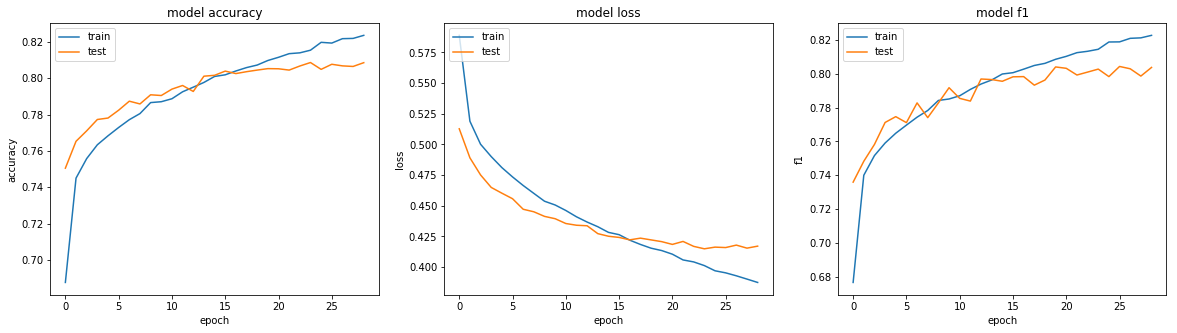

In [51]:
print(rnn_lstm_50_50_l.model.summary())

utilities.plot_history(rnn_lstm_50_50_l.history)

utilities.print_evaluation(rnn_lstm_50_50_l.model, dev_data, y_dev)

#### LSTM size: 50, MLP size: 50, with deep self-attention

In [52]:
LSTM_NUM_NEURONS = 50
DENSE_NUM_NEURONS = 50
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [53]:
rnn_lstm_50_50_d = RNN()
rnn_lstm_50_50_d = rnn_lstm_50_50_d \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .lstm_layer(
        units = LSTM_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'lstm_layer'
    ) \
    .deep_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [54]:
rnn_lstm_50_50_d = rnn_lstm_50_50_d.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/LSTM_50_50_d'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.74127, saving model to models/LSTM_50_50_d



Epoch 00002: val_f1 improved from 0.74127 to 0.75820, saving model to models/LSTM_50_50_d



Epoch 00003: val_f1 improved from 0.75820 to 0.77225, saving model to models/LSTM_50_50_d



Epoch 00004: val_f1 did not improve from 0.77225



Epoch 00005: val_f1 improved from 0.77225 to 0.77722, saving model to models/LSTM_50_50_d



Epoch 00006: val_f1 improved from 0.77722 to 0.79010, saving model to models/LSTM_50_50_d



Epoch 00007: val_f1 did not improve from 0.79010



Epoch 00008: val_f1 improved from 0.79010 to 0.79501, saving model to models/LSTM_50_50_d



Epoch 00009: val_f1 improved from 0.79501 to 0.80084, saving model to models/LSTM_50_50_d



Epoch 00010: val_f1 did not improve from 0.80084



Epoch 00011: val_f1 did not improve from 0.80084



Epoch 00012: val_f1 did not improve from 0.80084



Epoch 00013: val_f1 improved from 0.80084 to 0.80323, saving model to models/LSTM_50_50_d



Epoch 00014: val_f1 did not improve from 0.80323



Epoch 00015: val_f1 improved from 0.80323 to 0.80384, saving model to models/LSTM_50_50_d



Epoch 00016: val_f1 improved from 0.80384 to 0.80603, saving model to models/LSTM_50_50_d



Epoch 00017: val_f1 did not improve from 0.80603



Epoch 00018: val_f1 did not improve from 0.80603



Epoch 00019: val_f1 did not improve from 0.80603



Epoch 00020: val_f1 did not improve from 0.80603



Epoch 00021: val_f1 did not improve from 0.80603



Epoch 00022: val_f1 did not improve from 0.80603



Epoch 00023: val_f1 did not improve from 0.80603



Epoch 00024: val_f1 did not improve from 0.80603



Epoch 00025: val_f1 did not improve from 0.80603



Epoch 00026: val_f1 did not improve from 0.80603



Epoch 00027: val_f1 did not improve from 0.80603



Epoch 00028: val_f1 did not improve from 0.80603



Epoch 00029: val_f1 did not improve from 0.80603
Epoch 00029: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
lstm_layer (Bidirectional)   (None, 100, 100)          140400    
_________________________________________________________________
deep_attention_5 (DeepAttent (None, 100)               10201     
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 100)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 50)                5050      
__________

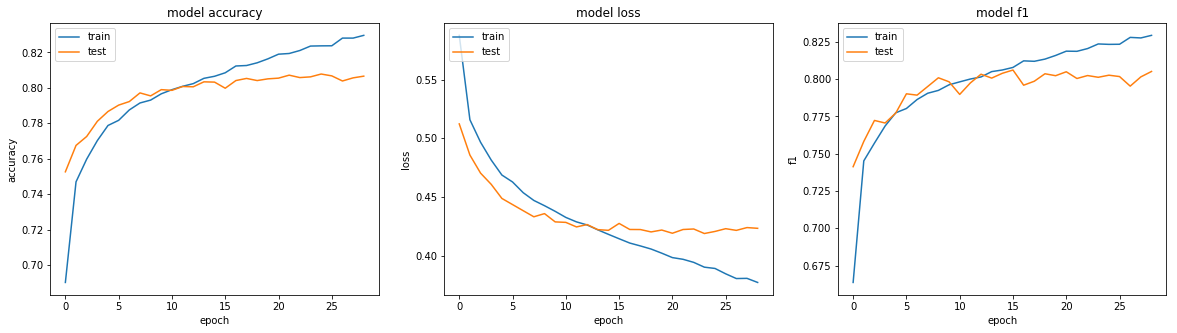

In [55]:
print(rnn_lstm_50_50_d.model.summary())

utilities.plot_history(rnn_lstm_50_50_d.history)

utilities.print_evaluation(rnn_lstm_50_50_d.model, dev_data, y_dev)

Monitoring the performance of *deep* versus *linear* self attention and making sure all parameters are equal, we come to the conclusion that the experiments that will follow should keep the *linear* attention layer and focus on the number of GRU cells of the RNN.

#### LSTM size: 100, MLP size: 100, linear self-attention

In [56]:
LSTM_NUM_NEURONS = 100
DENSE_NUM_NEURONS = 100
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [57]:
rnn_lstm_100_100_l = RNN()
rnn_lstm_100_100_l = rnn_lstm_100_100_l \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .lstm_layer(
        units = LSTM_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'lstm_layer'
    ) \
    .linear_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [58]:
rnn_lstm_100_100_l = rnn_lstm_100_100_l.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/LSTM_100_100_l'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.75278, saving model to models/LSTM_100_100_l



Epoch 00002: val_f1 improved from 0.75278 to 0.75895, saving model to models/LSTM_100_100_l



Epoch 00003: val_f1 improved from 0.75895 to 0.77480, saving model to models/LSTM_100_100_l



Epoch 00004: val_f1 did not improve from 0.77480



Epoch 00005: val_f1 improved from 0.77480 to 0.78299, saving model to models/LSTM_100_100_l



Epoch 00006: val_f1 did not improve from 0.78299



Epoch 00007: val_f1 improved from 0.78299 to 0.78799, saving model to models/LSTM_100_100_l



Epoch 00008: val_f1 did not improve from 0.78799



Epoch 00009: val_f1 did not improve from 0.78799



Epoch 00010: val_f1 improved from 0.78799 to 0.79815, saving model to models/LSTM_100_100_l



Epoch 00011: val_f1 did not improve from 0.79815



Epoch 00012: val_f1 improved from 0.79815 to 0.79864, saving model to models/LSTM_100_100_l



Epoch 00013: val_f1 did not improve from 0.79864



Epoch 00014: val_f1 improved from 0.79864 to 0.80188, saving model to models/LSTM_100_100_l



Epoch 00015: val_f1 improved from 0.80188 to 0.80330, saving model to models/LSTM_100_100_l



Epoch 00016: val_f1 did not improve from 0.80330



Epoch 00017: val_f1 improved from 0.80330 to 0.80445, saving model to models/LSTM_100_100_l



Epoch 00018: val_f1 improved from 0.80445 to 0.80745, saving model to models/LSTM_100_100_l



Epoch 00019: val_f1 improved from 0.80745 to 0.80763, saving model to models/LSTM_100_100_l



Epoch 00020: val_f1 did not improve from 0.80763



Epoch 00021: val_f1 did not improve from 0.80763



Epoch 00022: val_f1 did not improve from 0.80763



Epoch 00023: val_f1 did not improve from 0.80763



Epoch 00024: val_f1 did not improve from 0.80763



Epoch 00025: val_f1 did not improve from 0.80763



Epoch 00026: val_f1 did not improve from 0.80763
Epoch 00026: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
lstm_layer (Bidirectional)   (None, 100, 200)          320800    
_________________________________________________________________
linear_attention_4 (LinearAt (None, 200)               201       
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 200)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 100)               20100     
__________

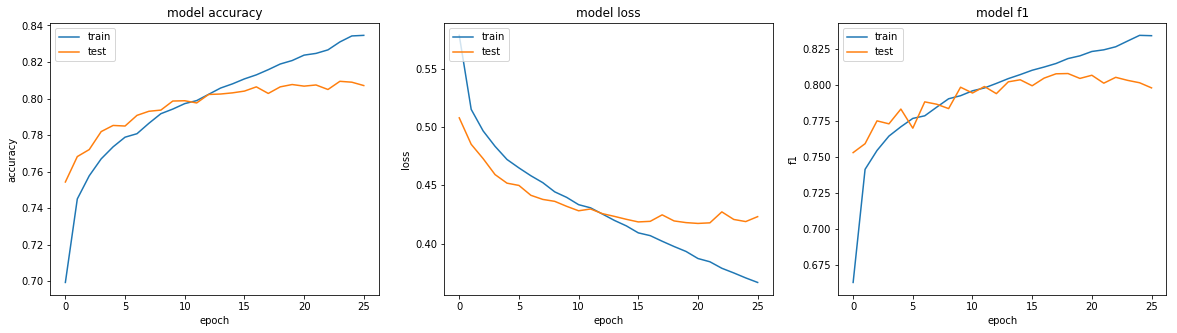

In [59]:
print(rnn_lstm_100_100_l.model.summary())

utilities.plot_history(rnn_lstm_100_100_l.history)

utilities.print_evaluation(rnn_lstm_100_100_l.model, dev_data, y_dev)

#### LSTM size: 100, MLP size: 100, deep self-attention

In [60]:
LSTM_NUM_NEURONS = 100
DENSE_NUM_NEURONS = 100
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [61]:
rnn_lstm_100_100_d = RNN()
rnn_lstm_100_100_d = rnn_lstm_100_100_d \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .lstm_layer(
        units = LSTM_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'lstm_layer'
    ) \
    .deep_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [62]:
rnn_lstm_100_100_d = rnn_lstm_100_100_d.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/LSTM_100_100_d'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.75624, saving model to models/LSTM_100_100_d



Epoch 00002: val_f1 improved from 0.75624 to 0.77198, saving model to models/LSTM_100_100_d



Epoch 00003: val_f1 improved from 0.77198 to 0.78083, saving model to models/LSTM_100_100_d



Epoch 00004: val_f1 improved from 0.78083 to 0.78356, saving model to models/LSTM_100_100_d



Epoch 00005: val_f1 did not improve from 0.78356



Epoch 00006: val_f1 improved from 0.78356 to 0.78722, saving model to models/LSTM_100_100_d



Epoch 00007: val_f1 did not improve from 0.78722



Epoch 00008: val_f1 improved from 0.78722 to 0.79542, saving model to models/LSTM_100_100_d



Epoch 00009: val_f1 improved from 0.79542 to 0.79885, saving model to models/LSTM_100_100_d



Epoch 00010: val_f1 improved from 0.79885 to 0.80452, saving model to models/LSTM_100_100_d



Epoch 00011: val_f1 did not improve from 0.80452



Epoch 00012: val_f1 did not improve from 0.80452



Epoch 00013: val_f1 did not improve from 0.80452



Epoch 00014: val_f1 did not improve from 0.80452



Epoch 00015: val_f1 improved from 0.80452 to 0.80807, saving model to models/LSTM_100_100_d



Epoch 00016: val_f1 did not improve from 0.80807



Epoch 00017: val_f1 did not improve from 0.80807



Epoch 00018: val_f1 did not improve from 0.80807



Epoch 00019: val_f1 did not improve from 0.80807
Epoch 00019: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
lstm_layer (Bidirectional)   (None, 100, 200)          320800    
_________________________________________________________________
deep_attention_6 (DeepAttent (None, 200)               40401     
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 200)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 100)               20100     
__________

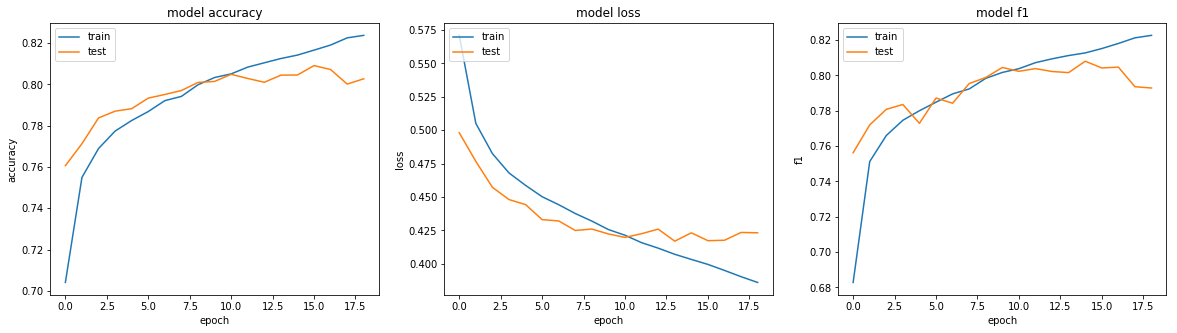

In [63]:
print(rnn_lstm_100_100_d.model.summary())

utilities.plot_history(rnn_lstm_100_100_d.history)

utilities.print_evaluation(rnn_lstm_100_100_d.model, dev_data, y_dev)

Noticing that the f1 score increases slightly, we attribute the increase in performance to the number of neurons of the GRU and MLP layer, we therefore we shall proceed with testing yet another model with an increased number of such parameters.

#### LSTM size: 200, MLP size: 200, deep self-attention

In [64]:
LSTM_NUM_NEURONS = 200
DENSE_NUM_NEURONS = 200
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [65]:
rnn_lstm_200_200_d = RNN()
rnn_lstm_200_200_d = rnn_lstm_200_200_d \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .lstm_layer(
        units = LSTM_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'lstm_layer'
    ) \
    .deep_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [66]:
rnn_lstm_200_200_d = rnn_lstm_200_200_d.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/LSTM_200_200_d'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.74324, saving model to models/LSTM_200_200_d



Epoch 00002: val_f1 improved from 0.74324 to 0.77100, saving model to models/LSTM_200_200_d



Epoch 00003: val_f1 improved from 0.77100 to 0.78310, saving model to models/LSTM_200_200_d



Epoch 00004: val_f1 did not improve from 0.78310



Epoch 00005: val_f1 improved from 0.78310 to 0.79169, saving model to models/LSTM_200_200_d



Epoch 00006: val_f1 improved from 0.79169 to 0.79367, saving model to models/LSTM_200_200_d



Epoch 00007: val_f1 improved from 0.79367 to 0.79484, saving model to models/LSTM_200_200_d



Epoch 00008: val_f1 improved from 0.79484 to 0.79496, saving model to models/LSTM_200_200_d



Epoch 00009: val_f1 improved from 0.79496 to 0.79986, saving model to models/LSTM_200_200_d



Epoch 00010: val_f1 did not improve from 0.79986



Epoch 00011: val_f1 did not improve from 0.79986



Epoch 00012: val_f1 improved from 0.79986 to 0.80281, saving model to models/LSTM_200_200_d



Epoch 00013: val_f1 improved from 0.80281 to 0.80494, saving model to models/LSTM_200_200_d



Epoch 00014: val_f1 did not improve from 0.80494



Epoch 00015: val_f1 improved from 0.80494 to 0.80507, saving model to models/LSTM_200_200_d



Epoch 00016: val_f1 did not improve from 0.80507



Epoch 00017: val_f1 did not improve from 0.80507



Epoch 00018: val_f1 improved from 0.80507 to 0.80533, saving model to models/LSTM_200_200_d



Epoch 00019: val_f1 did not improve from 0.80533
Epoch 00019: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
lstm_layer (Bidirectional)   (None, 100, 400)          801600    
_________________________________________________________________
deep_attention_7 (DeepAttent (None, 400)               160801    
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 400)               0         
_________________________________________________________________
mlp_layer (Dense)            (None, 200)               80200     
__________

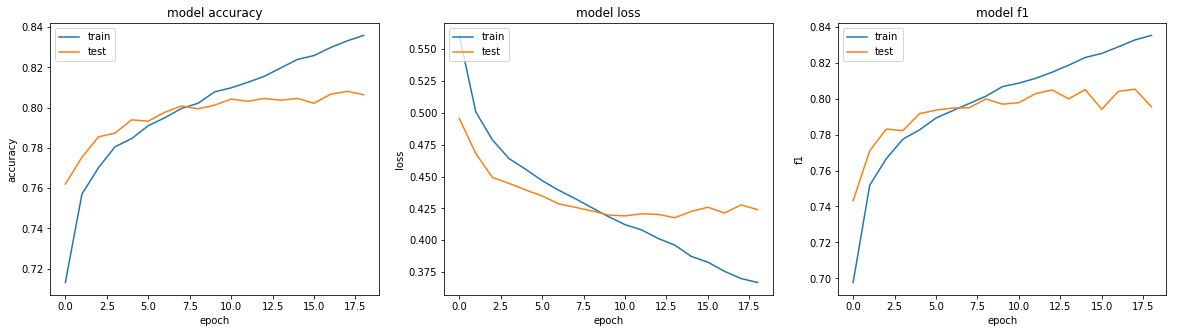

In [67]:
print(rnn_lstm_200_200_d.model.summary())

utilities.plot_history(rnn_lstm_200_200_d.history)

utilities.print_evaluation(rnn_lstm_200_200_d.model, dev_data, y_dev)

#### 2 stacked LSTMs, GRU size: 100, MLP size: 100, with deep self-attention

In [68]:
LSTM_NUM_NEURONS = 100
DENSE_NUM_NEURONS = 100
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = fasttext_embed.shape[1]

In [69]:
rnn_lstm_100_100_stacked_l = RNN()
rnn_lstm_100_100_stacked_l = rnn_lstm_100_100_stacked_l \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM, 
        weights = embeddings_matrix,
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'embeddings_dropout_layer'
    ) \
    .lstm_layer(
        units = LSTM_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'lstm_layer_1'
    ) \
    .lstm_layer(
        units = LSTM_NUM_NEURONS,
        activation = 'tanh', 
        return_sequences = True, 
        recurrent_dropout = 0.2,
        name = 'lstm_layer_2'
    ) \
    .deep_attention_layer(
        return_attention = False
    ) \
    .dropout_layer(
        rate = 0.2,
        name = 'mlp_dropout_layer'
    ) \
    .dense_layer(
        units = DENSE_NUM_NEURONS, 
        activation = 'relu',
        name = 'mlp_layer'
    ) \
    .dense_layer(
        units = N_CLASSES, 
        activation = 'sigmoid',
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = [utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )

In [70]:
rnn_lstm_100_100_stacked_l = rnn_lstm_100_100_stacked_l.fit(
    train_data, 
    y_train,
    heldout_data, 
    y_heldout,
    batch_size = 500,
    epochs = 50,
    verbose = 0,
    callbacks = [checkpoint('models/LSTM_100_100_stacked_l'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)


Epoch 00001: val_f1 improved from -inf to 0.76285, saving model to models/LSTM_100_100_stacked_l



Epoch 00002: val_f1 improved from 0.76285 to 0.76563, saving model to models/LSTM_100_100_stacked_l



Epoch 00003: val_f1 improved from 0.76563 to 0.77477, saving model to models/LSTM_100_100_stacked_l



Epoch 00004: val_f1 improved from 0.77477 to 0.78276, saving model to models/LSTM_100_100_stacked_l



Epoch 00005: val_f1 improved from 0.78276 to 0.78502, saving model to models/LSTM_100_100_stacked_l



Epoch 00006: val_f1 improved from 0.78502 to 0.79230, saving model to models/LSTM_100_100_stacked_l



Epoch 00007: val_f1 improved from 0.79230 to 0.79371, saving model to models/LSTM_100_100_stacked_l



Epoch 00008: val_f1 did not improve from 0.79371



Epoch 00009: val_f1 improved from 0.79371 to 0.79741, saving model to models/LSTM_100_100_stacked_l



Epoch 00010: val_f1 improved from 0.79741 to 0.79750, saving model to models/LSTM_100_100_stacked_l



Epoch 00011: val_f1 improved from 0.79750 to 0.80556, saving model to models/LSTM_100_100_stacked_l



Epoch 00012: val_f1 did not improve from 0.80556



Epoch 00013: val_f1 improved from 0.80556 to 0.80595, saving model to models/LSTM_100_100_stacked_l



Epoch 00014: val_f1 did not improve from 0.80595



Epoch 00015: val_f1 improved from 0.80595 to 0.80880, saving model to models/LSTM_100_100_stacked_l



Epoch 00016: val_f1 did not improve from 0.80880



Epoch 00017: val_f1 did not improve from 0.80880



Epoch 00018: val_f1 did not improve from 0.80880



Epoch 00019: val_f1 did not improve from 0.80880



Epoch 00020: val_f1 did not improve from 0.80880



Epoch 00021: val_f1 did not improve from 0.80880
Epoch 00021: early stopping



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
lstm_layer_1 (Bidirectional) (None, 100, 200)          320800    
_________________________________________________________________
lstm_layer_2 (Bidirectional) (None, 100, 200)          240800    
_________________________________________________________________
deep_attention_8 (DeepAttent (None, 200)               40401     
_________________________________________________________________
mlp_dropout_layer (Dropout)  (None, 200)               0         
__________

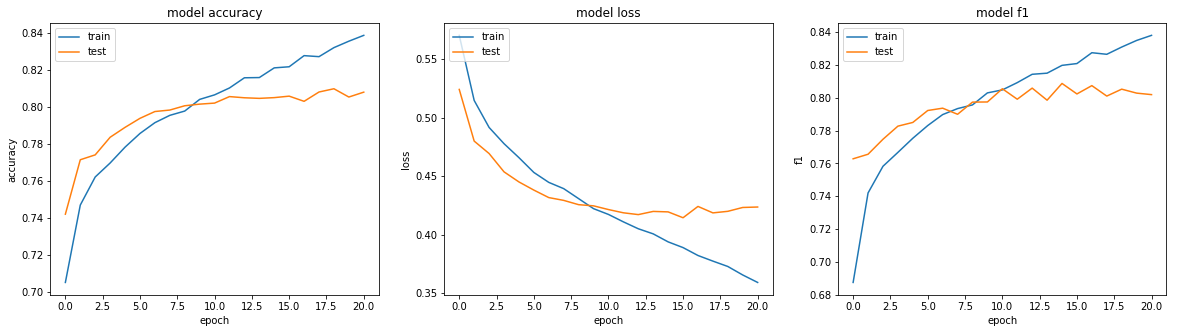

In [71]:
print(rnn_lstm_100_100_stacked_l.model.summary())

utilities.plot_history(rnn_lstm_100_100_stacked_l.history)

utilities.print_evaluation(rnn_lstm_100_100_stacked_l.model, dev_data, y_dev)

## Hyperparameter tuning

We have tuned parameters only for GRU cell because LSTM requires more time and we could not tune for all the parameters we wanted.
From the above exploration steps also we have seen that GRU had also better scores that RNN with LSTM cells so we didn't find any reason to continue with LSTM since we didn't see any improvements.

### Setup of Talos hyperparameters searching

In [72]:
GRU_NUM_NEURONS = 100
DENSE_NUM_NEURONS = 100
N_CLASSES = 1
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100

In [73]:
import talos as ta
from talos.model.early_stopper import early_stopper            
from talos.model.layers import hidden_layers

from keras.layers import InputLayer

def gru(x_train, y_train, x_dev, y_dev, parameters):
    from RNN import RNN
    
    rnn_gru = RNN()
    
    rnn_gru = rnn_gru \
    .input_layer(
        input_size = MAX_SEQUENCE_LENGTH,
        name = 'input_layer'
    ) \
    .embeddings_layer(
        input_dim = MAX_WORDS + 2, 
        output_dim = EMBEDDINGS_DIM,
        weights = embeddings_matrix, 
        input_length = MAX_SEQUENCE_LENGTH,
        name = 'embeddings_layer'
    ) \
    .dropout_layer(
        parameters = parameters,
        parameter_names = ['embeddings_dropout'],
        name = 'embeddings_dropout_layer'
    ) \
    .gru_layer(
        return_sequences = True, 
        parameters = parameters,
        parameter_names = ['gru_size', 'gru_recurrent_dropout'],
        name = 'gru_layer',
    )
    
    if(parameters['attention'] == 'linear'):
        rnn_gru = rnn_gru.linear_attention_layer(
            return_attention = False
        )
    elif(parameters['attention'] == 'deep'):
        rnn_gru = rnn_gru.deep_attention_layer(
            return_attention = False
        )
        
    rnn_gru = rnn_gru.dropout_layer(
        parameters = parameters,
        parameter_names = ['gru_dropout'],
        name = 'gru_dropout_layer'
    ) \
    .dense_layer(
        parameters = parameters,
        parameter_names = ['mlp_num_neurons', 'mlp_activation'],
        name = 'mlp_layer'
    ) \
    .dense_layer(
        parameters = parameters,
        parameter_names = ['output_num_neurons', 'output_layer_activation'],
        name = 'output_mlp_layer'
    ) \
    .compile(
        loss = 'binary_cross_entropy',
        optimizer = keras.optimizers.Adam(lr = 0.001),
        metrics = ['accuracy', utilities.precision, utilities.recall, utilities.f1, utilities.accuracy]
    )
    
    print(rnn_gru.model.summary())
    
    callbacks = [
        early_stopper(parameters['epochs'], mode = 'strict'),
        keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)
    ]
    
    rnn_gru = rnn_gru.fit(
        X_train = x_train, 
        y_train = y_train,
        X_validate = x_dev, 
        y_validate = y_dev, 
        batch_size = 500,
        epochs = parameters['epochs'],
        verbose = 0,
        callbacks = callbacks
    )
    
    return rnn_gru.history, rnn_gru.model

In [74]:
from keras.optimizers import Adam
from keras.activations import sigmoid
from keras.losses import binary_crossentropy

# Define the hyperparameters search space.
hyperparameters = {
    'learning_rate': [1e-3],
    'embeddings_dropout': [0.2],
    'gru_size': [100, 200, 300, 500],
    'gru_recurrent_dropout': [0.2],
    'gru_dropout':[0.2],
    'mlp_num_neurons': [32, 50, 64, 100, 500],
    'mlp_activation': ['relu'],
    'attention': ['linear', 'deep'],
    'optimizer': [Adam],
    'output_num_neurons': [1],
    'output_layer_activation': ['sigmoid'],
    'epochs': [50]
}

# Setup the Talos scan object.
talos_history = ta.Scan(
    x = train_data, 
    y = y_train, 
    x_val = heldout_data,
    y_val = y_heldout,
    params = hyperparameters,
    model = gru,
    # Random search parameter
    grid_downsample = 0.3,
    dataset_name = 'twitter-sentiment-analysis',
    print_params = True
)

  0%|          | 0/12 [00:00<?, ?it/s]

{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 100, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 64, 'mlp_activation': 'relu', 'attention': 'linear', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 200)          240600    
_________________________________________________________________
linear_attention_5 (Linear

  8%|▊         | 1/12 [05:05<56:04, 305.86s/it]

{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 300, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 500, 'mlp_activation': 'relu', 'attention': 'deep', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 600)          1081800   
_________________________________________________________________
deep_attention_1 (DeepAtten

 17%|█▋        | 2/12 [18:37<1:16:16, 457.65s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 200, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 32, 'mlp_activation': 'relu', 'attention': 'linear', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 400)          601200    
_________________________________________________________________
linear_attention_1 (Linea

 25%|██▌       | 3/12 [25:11<1:05:46, 438.45s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 200, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 500, 'mlp_activation': 'relu', 'attention': 'deep', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 400)          601200    
_________________________________________________________________
deep_attention_1 (DeepAtte

 33%|███▎      | 4/12 [33:30<1:00:54, 456.81s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 500, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 64, 'mlp_activation': 'relu', 'attention': 'deep', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 1000)         2403000   
_________________________________________________________________
deep_attention_1 (DeepAtten

 42%|████▏     | 5/12 [55:40<1:23:50, 718.63s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 100, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 64, 'mlp_activation': 'relu', 'attention': 'deep', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 200)          240600    
_________________________________________________________________
deep_attention_1 (DeepAtten

 50%|█████     | 6/12 [1:01:55<1:01:32, 615.46s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 500, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 32, 'mlp_activation': 'relu', 'attention': 'deep', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 1000)         2403000   
_________________________________________________________________
deep_attention_1 (DeepAtten

 58%|█████▊    | 7/12 [1:22:22<1:06:34, 798.89s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 500, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 100, 'mlp_activation': 'relu', 'attention': 'deep', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 1000)         2403000   
_________________________________________________________________
deep_attention_1 (DeepAtte

 67%|██████▋   | 8/12 [1:42:45<1:01:44, 926.09s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 300, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 500, 'mlp_activation': 'relu', 'attention': 'linear', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 600)          1081800   
_________________________________________________________________
linear_attention_1 (Line

 75%|███████▌  | 9/12 [1:52:21<41:03, 821.07s/it]  


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 100, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 32, 'mlp_activation': 'relu', 'attention': 'linear', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 200)          240600    
_________________________________________________________________
linear_attention_1 (Linea

 83%|████████▎ | 10/12 [1:57:40<22:21, 670.71s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 500, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 50, 'mlp_activation': 'relu', 'attention': 'linear', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 1000)         2403000   
_________________________________________________________________
linear_attention_1 (Linea

 92%|█████████▏| 11/12 [2:12:27<12:15, 735.37s/it]


{'learning_rate': 0.001, 'embeddings_dropout': 0.2, 'gru_size': 200, 'gru_recurrent_dropout': 0.2, 'gru_dropout': 0.2, 'mlp_num_neurons': 64, 'mlp_activation': 'relu', 'attention': 'deep', 'optimizer': <class 'keras.optimizers.Adam'>, 'output_num_neurons': 1, 'output_layer_activation': 'sigmoid', 'epochs': 50}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embeddings_layer (Embedding) (None, 100, 300)          6000600   
_________________________________________________________________
embeddings_dropout_layer (Dr (None, 100, 300)          0         
_________________________________________________________________
gru_layer (Bidirectional)    (None, 100, 400)          601200    
_________________________________________________________________
deep_attention_1 (DeepAtten

100%|██████████| 12/12 [2:21:59<00:00, 686.31s/it]

### Results

In [75]:
# Accessing the results data frame
display(talos_history.data)

,round_epochs,val_loss,val_acc,val_precision,val_recall,val_f1,val_accuracy,loss,acc,precision,...,gru_size,gru_recurrent_dropout,gru_dropout,mlp_num_neurons,mlp_activation,attention,optimizer,output_num_neurons,output_layer_activation,epochs
0,15,0.420356,0.80296,0.776914,0.728797,0.754669,0.80296,0.408327,0.813320,0.716510,...,100,0.2,0.2,64,relu,linear,<class 'keras.optimizers.Adam'>,1,sigmoid,50
1,14,0.421902,0.80280,0.742622,0.736934,0.765870,0.80280,0.381560,0.826453,0.732750,...,300,0.2,0.2,500,relu,deep,<class 'keras.optimizers.Adam'>,1,sigmoid,50
2,12,0.421028,0.80352,0.778649,0.731577,0.754069,0.80352,0.404132,0.814680,0.724492,...,200,0.2,0.2,32,relu,linear,<class 'keras.optimizers.Adam'>,1,sigmoid,50
3,14,0.419871,0.80400,0.770734,0.736729,0.770037,0.80400,0.395350,0.819333,0.734687,...,200,0.2,0.2,500,relu,deep,<class 'keras.optimizers.Adam'>,1,sigmoid,50
4,13,0.422689,0.80560,0.758141,0.750869,0.757413,0.80560,0.384034,0.824533,0.731648,...,500,0.2,0.2,64,relu,deep,<class 'keras.optimizers.Adam'>,1,sigmoid,50
5,18,0.419959,0.80504,0.778259,0.743041,0.759966,0.80504,0.397942,0.818573,0.716847,...,100,0.2,0.2,64,relu,deep,<class 'keras.optimizers.Adam'>,1,sigmoid,50
6,12,0.422392,0.80576,0.757557,0.714749,0.744264,0.80576,0.387154,0.821267,0.730627,...,500,0.2,0.2,32,relu,deep,<class 'keras.optimizers.Adam'>,1,sigmoid,50
7,12,0.424427,0.80144,0.764819,0.747676,0.755737,0.80144,0.395226,0.818507,0.734919,...,500,0.2,0.2,100,relu,deep,<class 'keras.optimizers.Adam'>,1,sigmoid,50
8,11,0.420852,0.80392,0.766451,0.757914,0.767840,0.80392,0.397135,0.817387,0.734327,...,300,0.2,0.2,500,relu,linear,<class 'keras.optimizers.Adam'>,1,sigmoid,50
9,16,0.422265,0.80288,0.776910,0.726117,0.750361,0.80288,0.405472,0.813347,0.716409,...,100,0.2,0.2,32,relu,linear,<class 'keras.optimizers.Adam'>,1,sigmoid,50


In [76]:
# Accessing epoch entropy values for each round
display(talos_history.peak_epochs_df)

,val_loss,val_acc,val_precision,val_recall,val_f1,val_accuracy,loss,acc,precision,recall,f1,accuracy,acc_epoch,loss_epoch
1,12,12,0,1,0,12,14,14,0,0,0,14,0.000228,0.000886
2,11,12,0,7,0,12,13,13,0,0,0,13,0.000220,0.001979
3,9,8,0,0,0,8,11,11,0,0,0,11,0.000217,0.000982
4,11,11,0,4,0,11,13,13,0,0,0,13,0.000229,0.001382
5,10,11,1,0,0,11,12,12,0,0,0,12,0.000213,0.001662
6,15,15,0,0,0,15,17,17,0,0,0,17,0.000238,0.001221
7,9,11,1,0,0,11,11,11,0,0,0,11,0.000181,0.001514
8,9,11,0,0,0,11,11,11,0,0,0,11,0.000211,0.001335
9,8,9,0,7,0,9,10,10,0,0,0,10,0.000222,0.001251
10,13,15,0,0,0,15,15,15,0,0,0,15,0.000217,0.000945


In [77]:
# Use the Talos scan object as input
report = ta.Reporting(talos_history)
display(report.table())
display(report.best_params())
display(report.high())

,val_accuracy,output_layer_activation,gru_size,val_precision,accuracy,learning_rate,val_recall,val_f1,output_num_neurons,val_acc,...,gru_recurrent_dropout,f1,embeddings_dropout,mlp_num_neurons,mlp_activation,gru_dropout,epochs,precision,attention,recall
6,0.80576,sigmoid,500,0.757557,0.821267,0.001,0.714749,0.744264,1,0.80576,...,0.2,0.706593,0.2,32,relu,0.2,50,0.730627,deep,0.694115
4,0.80560,sigmoid,500,0.758141,0.824533,0.001,0.750869,0.757413,1,0.80560,...,0.2,0.710891,0.2,64,relu,0.2,50,0.731648,deep,0.700819
11,0.80544,sigmoid,200,0.759015,0.823933,0.001,0.739501,0.768576,1,0.80544,...,0.2,0.713049,0.2,64,relu,0.2,50,0.726780,deep,0.707696
5,0.80504,sigmoid,100,0.778259,0.818573,0.001,0.743041,0.759966,1,0.80504,...,0.2,0.696088,0.2,64,relu,0.2,50,0.716847,deep,0.690644
3,0.80400,sigmoid,200,0.770734,0.819333,0.001,0.736729,0.770037,1,0.80400,...,0.2,0.716742,0.2,500,relu,0.2,50,0.734687,deep,0.709912
8,0.80392,sigmoid,300,0.766451,0.817387,0.001,0.757914,0.767840,1,0.80392,...,0.2,0.716199,0.2,500,relu,0.2,50,0.734327,linear,0.708395
2,0.80352,sigmoid,200,0.778649,0.814680,0.001,0.731577,0.754069,1,0.80352,...,0.2,0.704137,0.2,32,relu,0.2,50,0.724492,linear,0.696551
0,0.80296,sigmoid,100,0.776914,0.813320,0.001,0.728797,0.754669,1,0.80296,...,0.2,0.698324,0.2,64,relu,0.2,50,0.716510,linear,0.691218
9,0.80288,sigmoid,100,0.776910,0.813347,0.001,0.726117,0.750361,1,0.80288,...,0.2,0.691530,0.2,32,relu,0.2,50,0.716409,linear,0.681715
1,0.80280,sigmoid,300,0.742622,0.826453,0.001,0.736934,0.765870,1,0.80280,...,0.2,0.708907,0.2,500,relu,0.2,50,0.732750,deep,0.696922


array([[0.8057600045204163, 'sigmoid', 500, 0.7575570869445801,
        0.821266667842865, 0.001, 0.7147487449645996, 0.7442637133598328,
        1, "<class 'keras.optimizers.Adam'>", 0.2, 0.706592651406924,
        0.2, 32, 'relu', 0.2, 50, 0.7306272586186727, 'deep',
        0.6941151950756709, 0],
       [0.805600004196167, 'sigmoid', 500, 0.7581411910057068,
        0.8245333333810171, 0.001, 0.7508694314956665,
        0.7574133610725403, 1, "<class 'keras.optimizers.Adam'>", 0.2,
        0.7108905643224717, 0.2, 64, 'relu', 0.2, 50, 0.7316482563813528,
        'deep', 0.7008188304305076, 1],
       [0.8054399991035461, 'sigmoid', 200, 0.7590151190757751,
        0.8239333311716716, 0.001, 0.7395008063316345,
        0.7685759878158569, 1, "<class 'keras.optimizers.Adam'>", 0.2,
        0.7130491435527802, 0.2, 64, 'relu', 0.2, 50, 0.7267804725964864,
        'deep', 0.7076957184076309, 2],
       [0.8050399994850159, 'sigmoid', 100, 0.7782591986656189,
        0.8185733354091644,

0.8057600045204163

---